In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import os
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Untitled folder/cleaned_hm.csv')
df = data.copy()

In [3]:
df.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [4]:
df.isnull().sum()

hmid                         0
wid                          0
reflection_period            0
original_hm                  0
cleaned_hm                   0
modified                     0
num_sentence                 0
ground_truth_category    86410
predicted_category           0
dtype: int64

In [5]:
classes = df['predicted_category'].unique()
encode = [i for i in range(len(classes))]
classes_dict = dict(zip(classes,encode))

In [6]:
classes_dict

{'achievement': 4,
 'affection': 0,
 'bonding': 2,
 'enjoy_the_moment': 5,
 'exercise': 1,
 'leisure': 3,
 'nature': 6}

In [7]:
df = df[df['num_sentence'] < 20]
df['predicted_category'] = df['predicted_category'].apply(lambda x : classes_dict[x])
df = df[['cleaned_hm','predicted_category']]

In [8]:
text = df['cleaned_hm'].values.tolist()
categories = df['predicted_category'].values
corpus = []

In [9]:
for line in text :
    line_new = re.sub('[^a-zA-Z]',' ', line)
    words = word_tokenize(line_new)
    words = [w.lower() for w in words]
    words = list(set(words).difference(stopwords.words('english')))
    lemma = WordNetLemmatizer()
    words = [lemma.lemmatize(w) for w in words]
    corpus.append(words)

corpus[:5]

[['someone', 'felt', 'sympathy', 'connection', 'went', 'successful', 'date'],
 ['son', 'examination', 'mark', 'got', 'happy'],
 ['went', 'morning', 'yoga', 'gym'],
 ['serious',
  'evening',
  'understood',
  'friend',
  'flaky',
  'talk',
  'lately',
  'hanging',
  'good'],
 ['crohn', 'conservatory', 'went', 'butterfly', 'display', 'grandchild']]

In [10]:
val_split = 0.2
max_len = 50

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

word_index = tokenizer.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
categories = categories[indices]

n_values = np.max(categories) + 1
Y = np.eye(n_values)[categories]

num_validation_samples = int(val_split * lines_pad.shape[0])

x_train = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
x_test = lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]


print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

unique tokens - 21085
vocab_size - 21086
Shape of x_train: (80371, 50)
Shape of y_train: (80371, 7)
Shape of x_test: (20092, 50)
Shape of y_test: (20092, 7)


In [11]:
w2v_emb = Word2Vec(sentences=corpus, 
                   size=300, window=7, 
                   workers=4, min_count=2, sg=0) 
vocab_words = list(w2v_emb.wv.vocab)                                                                      
print(len(vocab_words))

12843


In [12]:
filename = "happydb_word2vec.txt"
w2v_emb.wv.save_word2vec_format(filename, binary=False)

In [13]:
embeddings_index = {}

f = open('/content/happydb_word2vec.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

In [14]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(units=64,  dropout=0.2, recurrent_dropout=0.25,unroll=True)))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           6325800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               140544    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 6,467,759
Trainable params: 141,703
Non-trainable params: 6,326,056
_________________________________________________________________
None


In [18]:
es = EarlyStopping(monitor = 'val_accuracy' , mode = 'max' , verbose = 1 , patience = 3)
rlr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2 , verbose = 1 , factor = 0.5 , min_lr = 0.0000001)
callbacks = [es,rlr]

history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/10
314/314 [==============================] - 207s 482ms/step - loss: 0.9387 - accuracy: 0.6933 - val_loss: 0.4881 - val_accuracy: 0.8310
Epoch 2/10
314/314 [==============================] - 144s 458ms/step - loss: 0.4791 - accuracy: 0.8287 - val_loss: 0.4343 - val_accuracy: 0.8456
Epoch 3/10
314/314 [==============================] - 143s 456ms/step - loss: 0.4347 - accuracy: 0.8410 - val_loss: 0.4169 - val_accuracy: 0.8513
Epoch 4/10
314/314 [==============================] - 142s 453ms/step - loss: 0.4160 - accuracy: 0.8475 - val_loss: 0.4087 - val_accuracy: 0.8534
Epoch 5/10
314/314 [==============================] - 143s 454ms/step - loss: 0.3991 - accuracy: 0.8535 - val_loss: 0.4076 - val_accuracy: 0.8552
Epoch 6/10
314/314 [==============================] - 142s 454ms/step - loss: 0.3901 - accuracy: 0.8572 - val_loss: 0.3934 - val_accuracy: 0.8587
Epoch 7/10
314/314 [==============================] - 142s 453ms/step - loss: 0.3864 - accuracy: 0.8584 - val_loss: 0.3943 -

[0.0, 0.0]

In [23]:
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.678504,0.776549,0.488083,0.831027,0.001
1,0.465134,0.833373,0.434299,0.845560,0.001
2,0.430893,0.842630,0.416860,0.851284,0.001
3,0.414839,0.848926,0.408729,0.853424,0.001
4,0.400360,0.853007,0.407561,0.855216,0.001


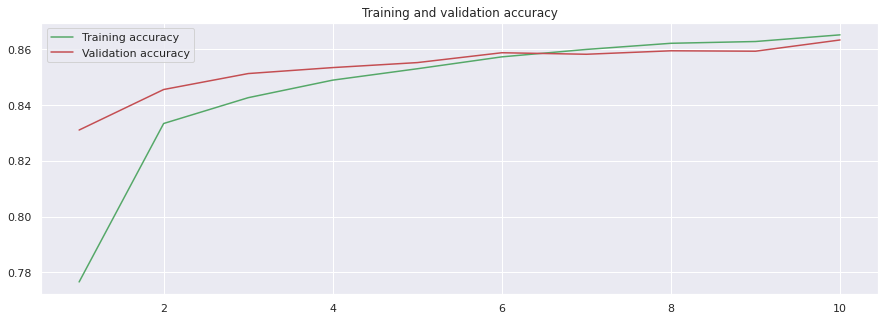

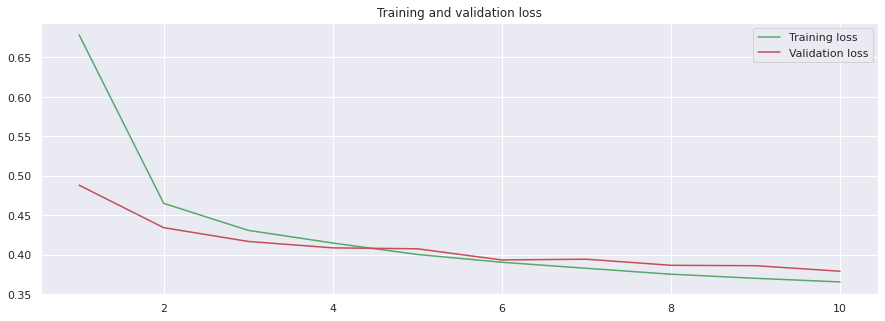

In [30]:
acc = df['accuracy']
val_acc = df['val_accuracy']
loss = df['loss']
val_loss = df['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()